In [16]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.callbacks import EarlyStopping
import pandas as pd
from sklearn import  metrics
from sklearn.datasets import make_moons
from mlxtend.plotting import plot_decision_regions

Wczytanie danych, usunięcie brakujących wartości, nadanie etykiet

In [2]:
train_set = pd.read_csv('adult/adult.data', sep=", ", header=None, engine='python')
test_set = pd.read_csv('adult/adult.test', sep=", ", skiprows=1, header=None, engine='python')

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
              'wage_class']

train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Zad.
Zróbmy szybki preprocesing

In [3]:
dataset = pd.concat([train, test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0, '<=50K': 0, '>50K.': 1, '>50K': 1})

dataset.drop(["fnlwgt"], axis=1, inplace=True)
dataset.drop(["education"], axis=1, inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()
d = dict(pd.cut(x[x.index != " United-States"], 5, labels=range(5)))
dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset, drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class", axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class", axis=1)
y_test = test.wage_class

In [5]:
history = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dense(50,activation="sigmoid"))
model.add(Dense(10,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771


2024-06-07 03:19:12.462346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-07 03:19:12.462386: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-07 03:19:12.462416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kjUbuntu): /proc/driver/nvidia/version does not exist
2024-06-07 03:19:12.462793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Non-trainable params: 0
_________________________________________________________________


In [6]:
model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

# Zad
nauczmy model z EarlyStopping

Musimy podać:
* miarę, która ma zostać użyta do zatrzymania modelu
* jak długo ma model ma czekać na otrzymanie lepszego parametru zanim się zatrzyma


In [8]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[early_stopping])

Epoch 1/100
943/943 [==============================] - 7s 5ms/step - loss: 0.4265 - accuracy: 0.7914 - val_loss: 0.3754 - val_accuracy: 0.8135
Epoch 2/100
943/943 [==============================] - 7s 7ms/step - loss: 0.3784 - accuracy: 0.8110 - val_loss: 0.3742 - val_accuracy: 0.8066
Epoch 3/100
943/943 [==============================] - 6s 6ms/step - loss: 0.3726 - accuracy: 0.8139 - val_loss: 0.3705 - val_accuracy: 0.8125
Epoch 4/100
943/943 [==============================] - 5s 5ms/step - loss: 0.3725 - accuracy: 0.8115 - val_loss: 0.3725 - val_accuracy: 0.8147
Epoch 5/100
943/943 [==============================] - 5s 5ms/step - loss: 0.3728 - accuracy: 0.8140 - val_loss: 0.3685 - val_accuracy: 0.8147
Epoch 6/100
943/943 [==============================] - 6s 7ms/step - loss: 0.3709 - accuracy: 0.8165 - val_loss: 0.3760 - val_accuracy: 0.8088
Epoch 7/100
943/943 [==============================] - 6s 7ms/step - loss: 0.3688 - accuracy: 0.8147 - val_loss: 0.3659 - val_accuracy: 0.8125

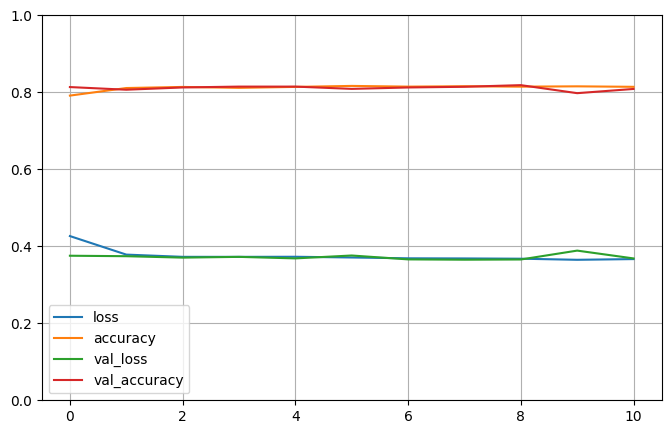

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [11]:
model.evaluate(X_test,y_test)

471/471 [==============================] - 2s 3ms/step - loss: 0.3684 - accuracy: 0.8086


[0.3684372305870056, 0.8086321353912354]

In [12]:
metrics.accuracy_score(y_true= y_test, y_pred= np.argmax(model.predict(X_test), axis=-1) )

471/471 [==============================] - 1s 925us/step


0.7543160690571049

# Zad.
Na poniższych danych naucz

* model bez EarlyStopping z 1000 epok
* model z wykorzystaniem EarlyStopping 
    dobierz paametr
    ```python
    patience=
    ```

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)




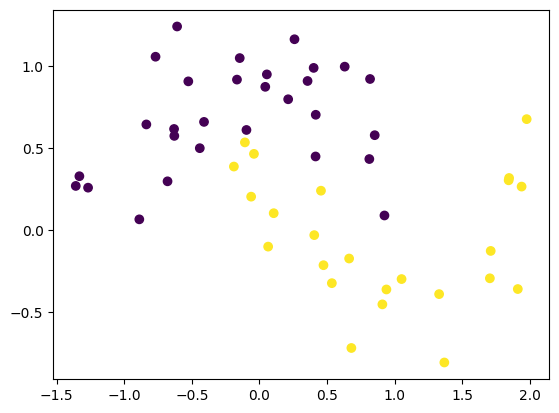

In [14]:
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [15]:
history_model1 = History()

model1 = Sequential()
model1.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model1.add(Dense(50,activation="sigmoid"))
model1.add(Dense(10,activation="sigmoid"))
model1.add(Dense(1,activation="sigmoid"))

model1.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])
history_model1 = model1.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=1000)

Epoch 1/1000
2/2 [==============================] - 2s 261ms/step - loss: 0.6881 - accuracy: 0.5472 - val_loss: 0.7022 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 43ms/step - loss: 0.6871 - accuracy: 0.5472 - val_loss: 0.7022 - val_accuracy: 0.4468
Epoch 3/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.6857 - accuracy: 0.5472 - val_loss: 0.7044 - val_accuracy: 0.4468
Epoch 4/1000
2/2 [==============================] - 0s 44ms/step - loss: 0.6849 - accuracy: 0.5472 - val_loss: 0.7060 - val_accuracy: 0.4468
Epoch 5/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.6844 - accuracy: 0.5472 - val_loss: 0.7068 - val_accuracy: 0.4468
Epoch 6/1000
2/2 [==============================] - 0s 49ms/step - loss: 0.6837 - accuracy: 0.5472 - val_loss: 0.7054 - val_accuracy: 0.4468
Epoch 7/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.6825 - accuracy: 0.5472 - val_loss: 0.7045 - val_accuracy: 0.4468
Epoch 8/1000

In [25]:
history_model2 = History()

model2 = Sequential()
model2.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model2.add(Dense(50,activation="sigmoid"))
model2.add(Dense(10,activation="sigmoid"))
model2.add(Dense(1,activation="sigmoid"))

model2.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='val_loss', patience=90, mode='min', verbose=1)
history_model2 = model2.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=1000, callbacks=[early_stopping])

Epoch 1/1000
2/2 [==============================] - 2s 261ms/step - loss: 0.8478 - accuracy: 0.5472 - val_loss: 0.9526 - val_accuracy: 0.4468
Epoch 2/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.8183 - accuracy: 0.5472 - val_loss: 0.9189 - val_accuracy: 0.4468
Epoch 3/1000
2/2 [==============================] - 0s 54ms/step - loss: 0.7964 - accuracy: 0.5472 - val_loss: 0.8874 - val_accuracy: 0.4468
Epoch 4/1000
2/2 [==============================] - 0s 93ms/step - loss: 0.7784 - accuracy: 0.5472 - val_loss: 0.8591 - val_accuracy: 0.4468
Epoch 5/1000
2/2 [==============================] - 0s 56ms/step - loss: 0.7587 - accuracy: 0.5472 - val_loss: 0.8345 - val_accuracy: 0.4468
Epoch 6/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7429 - accuracy: 0.5472 - val_loss: 0.8129 - val_accuracy: 0.4468
Epoch 7/1000
2/2 [==============================] - 0s 81ms/step - loss: 0.7304 - accuracy: 0.5472 - val_loss: 0.7939 - val_accuracy: 0.4468
Epoch 8/1000

In [26]:
histories = [history_model1, history_model2]
labels = ["model", "model + EarlyStopping"]
models = [model1, model2]

In [31]:
def plot_learning_curves(history, ax=None, label=''):
    ax = ax or plt.gca()
    ax.plot(history.history['loss'], label='loss')
    ax.plot(history.history['val_loss'], label='val_loss ')
    ax.set_title(label)
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 1000])
    ax.legend()

In [28]:
def plot_boundaries(model, *, ax=None, plot_training=True, title=None):
    ax = ax or plt.gca()
    plot_decision_regions(X_test, y_test, model, ax=ax)
    ax.set_title(title)
    if plot_training:
        ax.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 'bs', label='train 0')
        ax.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 'r^', label='train 1')
        ax.legend()

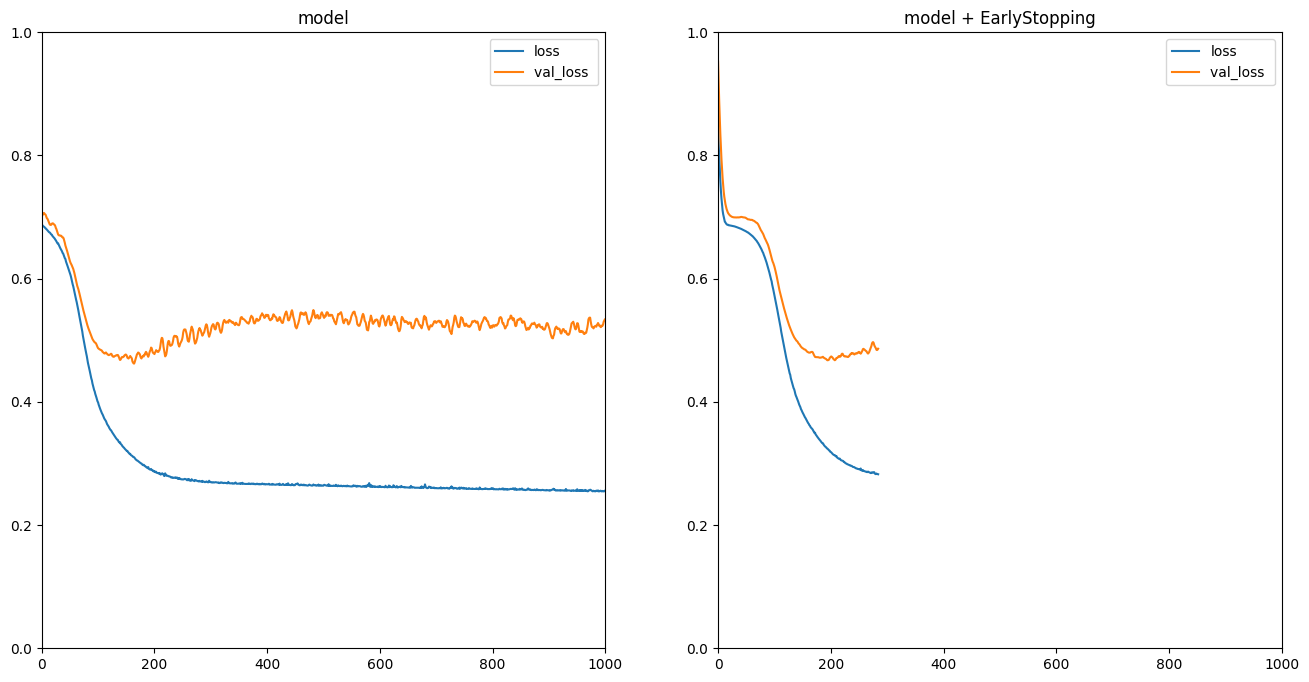

In [32]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))

for model, label, ax in zip(histories, labels, axs.flatten()):
    plot_learning_curves(model, ax, label)

40000/40000 [==============================] - 100s 3ms/step


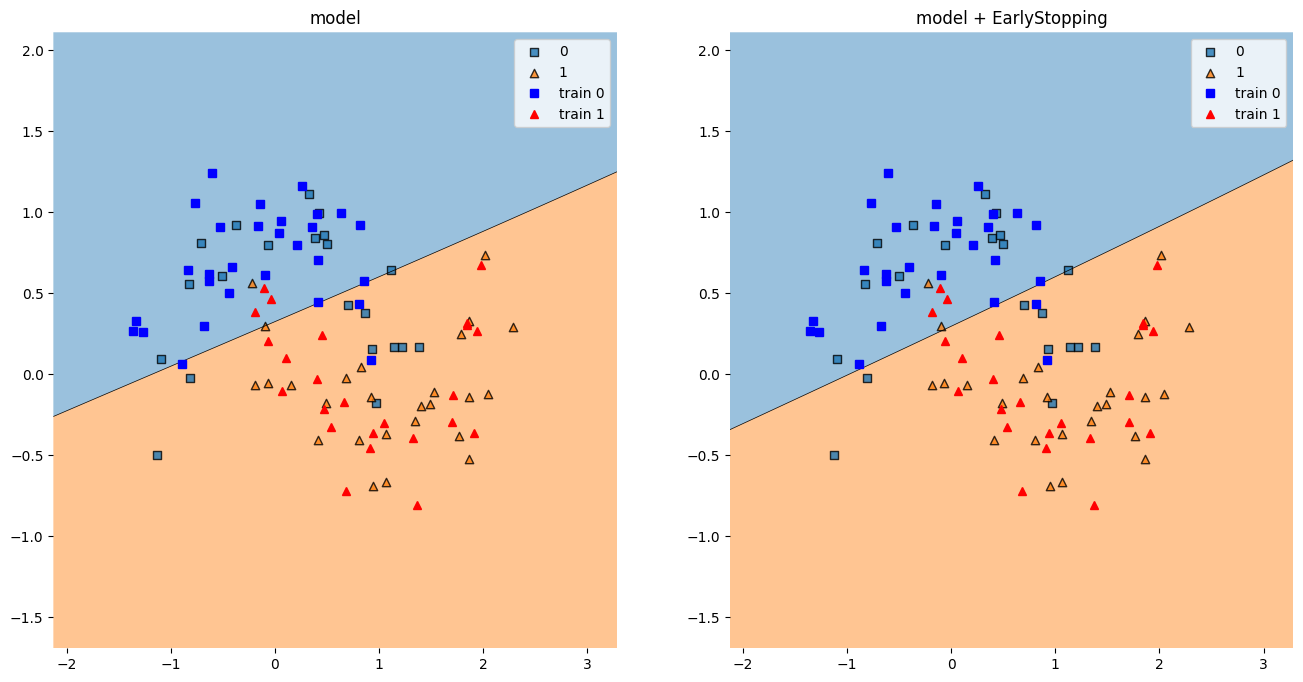

In [30]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))

for model, label, ax in zip(models, labels, axs.flatten()):
    plot_boundaries(model, ax=ax, title=label)